In [66]:
import os
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import Runnable
import operator
from typing import Annotated, Sequence, TypedDict, List
from langchain_core.messages import BaseMessage
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import StateGraph, END
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


In [39]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
  prompt = ChatPromptTemplate.from_messages(
    [
      ("system", system_prompt),
      MessagesPlaceholder(variable_name="messages"),
      MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
  )
  agent = create_openai_tools_agent(llm, tools, prompt)
  return AgentExecutor(agent=agent, tools=tools)

In [40]:
def create_supervisor(llm: ChatOpenAI, agents: list[str]):
  system_prompt = (
    "You are the supervisor over the following agents: {agents}."
    " You are responsible for assigning tasks to each agent as requested by the user."
        " Each agent executes tasks according to their roles and responds with their results and status."
        " Please review the information and answer with the name of the agent to which the task should be assigned next."
        " Answer 'FINISH' if you are satisfied that you have fulfilled the user's request."
  )

  options = ["FINISH"] + agents
  function_def = {
    "name": "supervisor",
    "description": "Select the next agent.",
    "parameters": {
      "type": "object",
      "properties": {
        "next": {
          "anyOf": [
            {"enum": options},
          ],
        }
      },
      "required": ["next"],
    },
  }

  prompt = ChatPromptTemplate.from_messages(
    [
      ("system", system_prompt),
      MessagesPlaceholder(variable_name="messages"),
      (
        "system",
        "In light of the above conversation, please select one of the following options for which agent should be act or end next: {options}."
      ),
    ]
  ).partial(options=str(options), agents=", ".join(agents))
  return (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="supervisor")
    | JsonOutputFunctionsParser()
  )

In [41]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from duckduckgo_search import DDGS

@tool("Trading_Research")
def researcher(query: str) -> str:
  """Research by Yahoo"""
  # Yfinance = YahooFinanceNewsTool()
  # return Yfinance.run(query)
  return DDGS().chat(query, model="gpt-4o-mini")

In [42]:
@tool("Market Analysist")
def analyze(content: str) -> str:
  """Market Analyser"""
  chat = ChatOpenAI(model="gpt-4o-mini")
  messages = [
  SystemMessage(
    content="Act as a day trading assistant. Your task is to identify trading assets that meet the specified {User_input}"
            "Utilize your expertise and available market analysis tools to scan, filter, and evaluate potential assets for trading." 
            "Once identified, create a comprehensive list with supporting data for each asset, indicating why it meets the criteria. "
            "Ensure that all information is up-to-date and relevant to the current market conditions. "
    ),
    HumanMessage(
      content=content
    ),
  ]
  response = chat(messages)
  return response.content

In [43]:
@tool("Trade Execution")
def executer(content: str) -> str:
  """Execute a trade"""
  chat = ChatOpenAI(model="gpt-4o-mini")
  messages = [
  SystemMessage(
    content="Act as an experienced trading assistant. Based on your comprehensive analysis of current market conditions,"
            "historical data, and emerging trends, decide on optimal entry, stop-loss, and target points for a specified "
            "trading asset. Begin by thoroughly reviewing recent price action, key technical indicators, and relevant news"
            "that might influence the asset's direction."
    ),
    HumanMessage(
      content=content
    ),
  ]
  response = chat(messages)
  return response.content

In [44]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [45]:
def researcher_agent() -> Runnable:
  prompt = (
    "You are an Trader research assistant, you uses Yahoo Fiance News to find the most up-to-date and correct information."
    "Your research should be rigorous, data-driven, and well-documented"
  )
  return create_agent(llm, [researcher], prompt)

def analyzer_agent() -> Runnable:
  prompt = (
    "As a Market Stock Analyzer, your main job is to study the stock market and "
    "help people make smart decisions about their investments "
  )
  return create_agent(llm, [analyze], prompt)

def executor_agent() -> Runnable:
  prompt = (
    "You are a Executor in the stock market, your job is to help people invest their money wisely."
    "You study how the stock market works and figure out which companies are good to invest in."
  )
  return create_agent(llm, [analyze], prompt)

In [55]:
RESEARCHER = "RESEARCHER"
ANALYZER = "Analyzer"
EXECUTOR = "Executor"
SUPERVISOR = "SUPERVISOR"
FINISH = "FINISH"

agents = [RESEARCHER, ANALYZER, EXECUTOR]

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  next: str

In [71]:
def researcher_node(state: AgentState) -> dict:
  print("DEBUG the state", state)
  result = researcher_agent().invoke(state)
  print("DEBUG the result", result)
  return {"messages": [HumanMessage(content=result["output"], name=RESEARCHER)]}

def Analyzer_node(state: AgentState) -> dict:
  result = analyzer_agent().invoke(state)
  return {"messages": [HumanMessage(content=result["output"], name=ANALYZER)]}

def Executor_node(state: AgentState) -> dict:
  result = executor_agent().invoke(state)
  return {"messages": [HumanMessage(content=result["output"], name=EXECUTOR)]}

def supervisor_node(state: AgentState) -> Runnable:
  return create_supervisor(llm, agents)

In [72]:
workflow = StateGraph(AgentState)

workflow.add_node(RESEARCHER, researcher_node)
workflow.add_node(ANALYZER, Analyzer_node)
workflow.add_node(EXECUTOR, Executor_node)
workflow.add_node(SUPERVISOR, supervisor_node)

workflow.add_edge(RESEARCHER, SUPERVISOR)
workflow.add_edge(ANALYZER, SUPERVISOR)
workflow.add_edge(EXECUTOR, SUPERVISOR)
workflow.add_conditional_edges(
  SUPERVISOR,
  lambda x: x["next"],
  {
    RESEARCHER: RESEARCHER,
    ANALYZER: ANALYZER,
    EXECUTOR: EXECUTOR,
    FINISH: END
  }
)

workflow.set_entry_point(SUPERVISOR)

graph = workflow.compile()

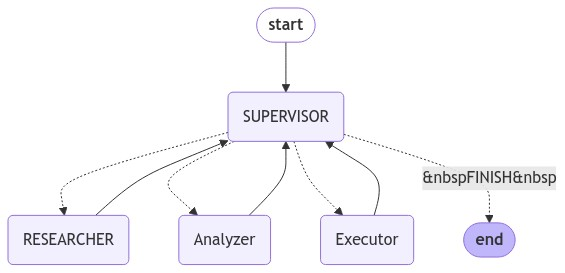

In [73]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [75]:
user_input = "Cổ phiếu ngân hàng ACB như thế nào?"

answer = graph.invoke({"messages": [HumanMessage(content=user_input)]}, debug=True)
answer


[-2:checkpoint] State at the end of step -2:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')]
[-2:checkpoint] State at the end of step -2:
{'messages': [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')]}
[1:tasks] Starting step 1 with 1 task:
- SUPERVISOR -> {'messages': [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')],
 'next': None}
[1:writes] Finished step 1 with writes to 1 channel:
- next -> 'RESEARCHER'
[-2:checkpoint] State at the end of step -2:
{'messages': [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')],
 'next': 'RESEARCHER'}
[2:tasks] Starting step 2 with 1 task:
- RESEARCHER -> {'messages': [HumanMessage(content='Cổ phiếu ngân hàng ACB như thế nào?')],
 'next': 'RESEARCHER'}
DEBUG the state {'messages': [HumanMes

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.